In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
print(df_users.shape)
display(df_users.head())

(116, 55)


,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")

df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)

df_evals.index = [f"u{u}" for u in df_evals["id"]]

In [4]:
topics = list("abcdefgh")
deltas = ["10", "21", "32", "43", "54"]

In [5]:
timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()

In [6]:
u_change = {
    u: {t: (np.array(get_change(u, t)) != 0).sum() for t in topics}
    for u in df_evals.index
}

## get events

+ post events -> nodes
+ comment events -> nodes
+ view events -> edges
+ like events -> edges
+ report events

In [7]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [8]:
df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

In [9]:
df_likes

,id,like,createdAt,updatedAt,UserId,PostId
0,48,t,2020-09-03 08:20:57.729000+00:00,2020-09-03 08:20:57.744+00,2443,107
1,24,t,2020-09-03 02:41:52.323000+00:00,2020-09-03 02:41:52.337+00,2580,98
2,25,t,2020-09-03 03:12:17.092000+00:00,2020-09-03 03:12:17.101+00,2622,107
3,77,t,2020-09-03 12:19:24.224000+00:00,2020-09-03 12:19:24.233+00,2481,127
4,26,t,2020-09-03 03:20:20.992000+00:00,2020-09-03 03:20:21.001+00,2604,100
...,...,...,...,...,...,...
1032,1094,t,2020-09-08 15:46:22.553000+00:00,2020-09-08 15:46:22.571+00,2575,1042
1033,1095,t,2020-09-08 16:12:55.093000+00:00,2020-09-08 16:12:55.101+00,2622,1031
1034,1096,t,2020-09-08 16:13:57.817000+00:00,2020-09-08 16:13:57.841+00,2709,1090
1035,1097,t,2020-09-08 17:02:43.273000+00:00,2020-09-08 17:02:43.289+00,2709,1030


### create auxiliary graph

In [10]:
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, author, t, senti, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "labels", "scores", "topic_label"]].values:
    G.add_node(f"p{p}", id=p, kind="post", time=t, user=author, senti=senti, score=score, topic=topic)

for c, author, t, senti, score, topic in df_comts[["id", "CommenterId", "createdAt", "labels", "scores", "topic_label"]].values:
    G.add_node(f"c{c}", id=c, kind="comt", time=t, user=author, senti=senti, score=score, topic=topic)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    p_name = f"p{p}" if p in df_posts["PostID"] else f"c{p}"
    if f"u{u}" in G.nodes and p_name in G.nodes:
        G.add_node(f"l{l}", user=u, post=p_name, time=t, id=l, kind="like",
                   topic=G.nodes[p_name]["topic"], senti="like", score=1)

In [11]:
# add views
for u, p, t, i in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    p_name = f"p{p}" if p in df_posts["PostID"] else f"c{p}"
    if f"u{u}" in G.nodes and p_name in G.nodes:
        G.add_edge(f"u{u}", p_name, time=t, id=i, kind="view")

# add likes
# for u, p, t, i in df_likes[["UserId", "PostId", "createdAt", "id"]].values:
#     p_name = f"p{p}" if p in df_posts["PostID"] else f"c{p}"
#     if f"u{u}" in G.nodes and p_name in G.nodes:
#         G.add_edge(f"u{u}", p_name, time=t, id=i, kind="like")
for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    p_name = f"p{p}" if p in df_posts["PostID"] else f"c{p}"
    if f"u{u}" in G.nodes and p_name in G.nodes:
        G.add_edge(f"u{u}", f"l{l}", user=u, post=p_name, time=t, id=l, kind="like")
        G.add_edge(f"l{l}", p_name, user=u, post=p_name, time=t, id=l, kind="like")

# add create
for p, u, t in df_posts[["PostID", "AuthorId", "createdAt"]].values:
    if f"u{u}" in G.nodes:
        G.add_edge(f"p{p}", f"u{u}", time=t, kind="make")

for c, u, t, in df_comts[["id", "CommenterId", "createdAt"]].values:
    if f"u{u}" in G.nodes:
        G.add_edge(f"c{c}", f"u{u}", time=t, kind="make")

# for c, u, t in df_comts[["PostId", "CommenterId", "createdAt"]].values:
#     if f"u{u}" in G.nodes and f"c{c}" in G.nodes:
#         G.add_edge(f"c{c}", f"u{u}", kind="comt_by", time=t)

In [12]:
def get_subgraph_with_node(G, node_name, topic="a"):
    # children = nx.descendants(G, source=node_name) | {node_name}
    tree = {
        e[1]: {
            "node": G.nodes[e[1]],
            "edge": G.edges[e],
            "time": G.edges[e]["time"],
        }
        # filter with topic
        for e in G.out_edges(node_name) if G.nodes[e[1]]["topic"] == topic
    }

    path = sorted(tree, key=lambda x: tree[x]["time"])
    
    return tree, path

In [13]:
node_name = "u2337"
topic = "a"

tree, path = get_subgraph_with_node(G, node_name, topic)

print(len(path))

12


#### define colors and styles for graph drawing

In [14]:
use_color = sns.color_palette("tab10")
use_color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [15]:
line_map = {
    "view": "-",
    "like": ".",
}

color_map = {
    "view": 4,
    "like": 1,
    
    "part": 2,
    "sock": 3,
    "obsr": 7,
    
    "make": 5,
    "comt": 9,
    "post": 0,
    
    "user": 8,
}

style_map = {
    "post": "o",
    "comt": "s",
}

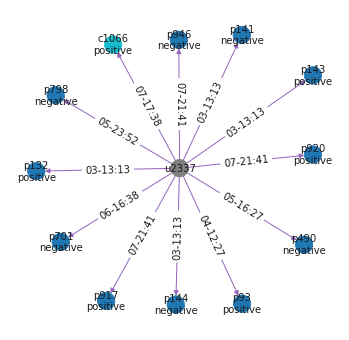

In [16]:
subG = nx.subgraph(G, path + [node_name])

pos = nx.spring_layout(subG, seed=3)
# pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog="dot")
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[subG.nodes[n]["color"]]]
                for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['senti']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
    edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges}
)

# ax.set_title(f"Auxilary graph")
print("")

In [17]:
user_timeline = {
    f"{node_name}_{i}": {
        "node": G.nodes[node_name],
        "time": timeline[i],
        "change": get_change(node_name, topic)[i-1] if i > 0 else 0,
    } for i in range(6)
}

print(user_timeline)

{'u2337_0': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False, 'color': 'obsr'}, 'time': Timestamp('2020-09-03 03:59:59+0000', tz='UTC', freq='D'), 'change': 0}, 'u2337_1': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False, 'color': 'obsr'}, 'time': Timestamp('2020-09-04 03:59:59+0000', tz='UTC', freq='D'), 'change': 3.0}, 'u2337_2': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False, 'color': 'obsr'}, 'time': Timestamp('2020-09-05 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}, 'u2337_3': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False, 'color': 'obsr'}, 'time': Timestamp('2020-09-06 03:59:59+0000', tz='UTC', freq='D'), 'change': 0.0}, 'u2337_4': {'node': {'id': 2337, 'kind': 'user', 'name': 'Luke_8468', 'observer': True, 'sock': False, 'color': 'obsr'}, 'time': Timestamp('2020-09-07 03:59:59+0000', tz='UTC', freq='D'

In [18]:
tree_full = {**tree, **user_timeline}
path_full = sorted(path + list(user_timeline.keys()), key=lambda x: tree_full[x]["time"])

pathG = nx.DiGraph()

pathG.add_nodes_from(path_full)

for i in range(len(path_full)):
    for j in range(i+1, len(path_full)):
        x = path_full[i]
        y = path_full[j]
        if y[0] == "u" and x[0] != "u":
            pathG.add_edge(y, x, **G.edges[(y[:-2], x)])
            break

nx.set_node_attributes(
    pathG,
    {
        n: {
           "color": use_color[color_map[tree_full[n]["node"]["kind"]]],
        }
        for n in pathG.nodes
    }
)

nx.set_edge_attributes(
    pathG,
    {
        e: {"color": use_color[color_map[pathG.edges[e]["kind"]]]}
        for e in pathG.edges
    }
)

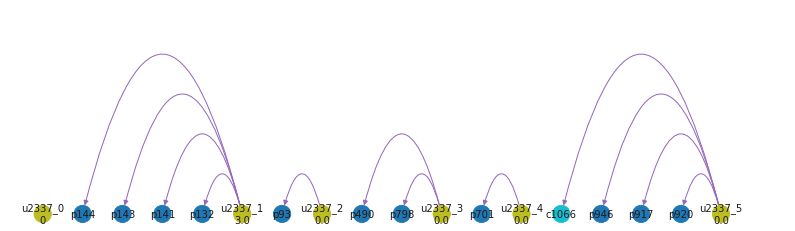

In [19]:
pos = {}
for n in pathG.nodes:
    pos[n] = np.array([len(pos), 0])

fig = plt.figure(figsize=(14, 4))
ax = fig.subplots()

nx.draw(
    pathG,
    pos=pos,
    ax=ax,
    with_labels=True,
    font_size=10,
    node_color=[pathG.nodes[n]["color"] for n in pathG.nodes],
    edge_color=[pathG.edges[e]["color"] for e in pathG.edges],
    labels={n: f"{n}" if n[0]!="u" else f"{n}\n{tree_full[n]['change']}" for n in pathG.nodes},
    connectionstyle="arc3,rad=2",
)

## full influence graph

In [20]:
node_name = "u2337"
topic = "a"

descend_full = [n for n in nx.descendants(G, node_name)
                if n[0] == "u" or G.nodes[n]["topic"] == topic]

np.random.seed(4)
# descend_full = np.random.choice(descend_full, 65, replace=False).tolist()

subG = G.subgraph(descend_full + [node_name]).copy()
print(len(subG))

subG = subG.subgraph([n for n in subG if nx.has_path(subG, node_name, n)])
print(len(subG))

180
96


96


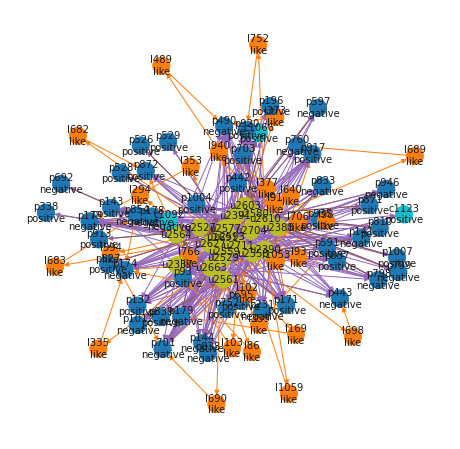

In [21]:
pos = nx.spring_layout(subG, iterations=6, seed=3)

fig = plt.figure(figsize=(8, 8))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]] for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['senti']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

# nx.draw_networkx_edge_labels(
#     subG, pos=pos, ax=ax,
#     edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges},
#     font_size=8,
# )

print(len(subG))

96


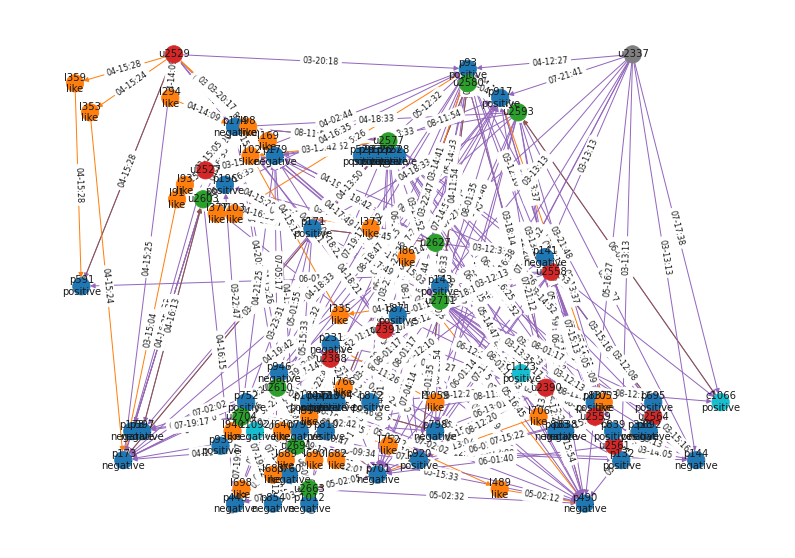

In [30]:
# pos = nx.spring_layout(subG, iterations=100)
pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog="dot")

fig = plt.figure(figsize=(14, 10))
ax = fig.subplots()

nx.draw(
    subG, ax=ax,
    pos=pos,
    with_labels=True,
#     node_color=[use_color[color_map[subG.nodes[n]["kind"]]] for n in subG.nodes],
    node_color=[use_color[color_map[subG.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[subG.nodes[n]["color"]]]
                for n in subG.nodes],
    edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
    labels={n: f"{n}\n{subG.nodes[n]['senti']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
    font_size=10,
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
    edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges},
    font_size=8,
)

print(len(subG))

In [26]:
attention_window = pd.Timedelta("1 day")
moment_time = timeline[5]
topic = "a"
pr_alpha = 0.85
beta_rv = beta(a=0.5, b=0.5)

node_name = "u2337"

print(f"{attention_window}, {moment_time}")

1 days 00:00:00, 2020-09-08 03:59:59+00:00


In [27]:
moment_nodes = [n for n in G if n[0] == "u" or G.nodes[n]["topic"] == topic]

moment_graph = G.subgraph(moment_nodes).copy()
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

# remove edges outside attention window
remove_edges = [e for e in moment_graph.edges if moment_graph.edges[e]["time"] > moment_time]
for n in moment_graph:
    if n[0] == "u" and not G.nodes[n]["observer"] and len(moment_graph.in_edges(n)) > 0:
        t_min = min([G.edges[e]["time"] for e in moment_graph.in_edges(n)])
        t_max = max([G.edges[e]["time"] for e in moment_graph.in_edges(n)])
        remove_edges += [e for e in moment_graph.out_edges(n) if not t_min - attention_window < moment_graph.edges[e]["time"] <= t_max]

print(f"remove edges {len(remove_edges)}")
moment_graph.remove_edges_from(remove_edges)
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

# for source node node_name only
descend_full = [n for n in nx.descendants(moment_graph, node_name)]
moment_graph = moment_graph.subgraph(descend_full + [node_name]).copy()
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")
moment_graph = moment_graph.subgraph([n for n in moment_graph if nx.has_path(moment_graph, node_name, n)]).copy()
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")

# remove isolated nodes
isolates = list(nx.isolates(moment_graph))
moment_graph.remove_nodes_from(isolates)
print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")


for node in moment_graph:
    elist = sorted(moment_graph.out_edges(node), key=lambda e: G.edges[e]["time"])
    x = np.linspace(0, 1, len(elist)+2)[1:-1]
    y = beta_rv.pdf(x)
    y = y / y.sum()
    for e, w in zip(elist, y):
        moment_graph.edges[e]["weight"] = w

pr_value = nx.pagerank_numpy(moment_graph, alpha=pr_alpha, weight="weight")

nodes 284, edges: 1416
remove edges 519
nodes 284, edges: 958
nodes 74, edges: 207
nodes 74, edges: 207
nodes 74, edges: 207


/home/rui/venvs/gcn/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: part is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


74


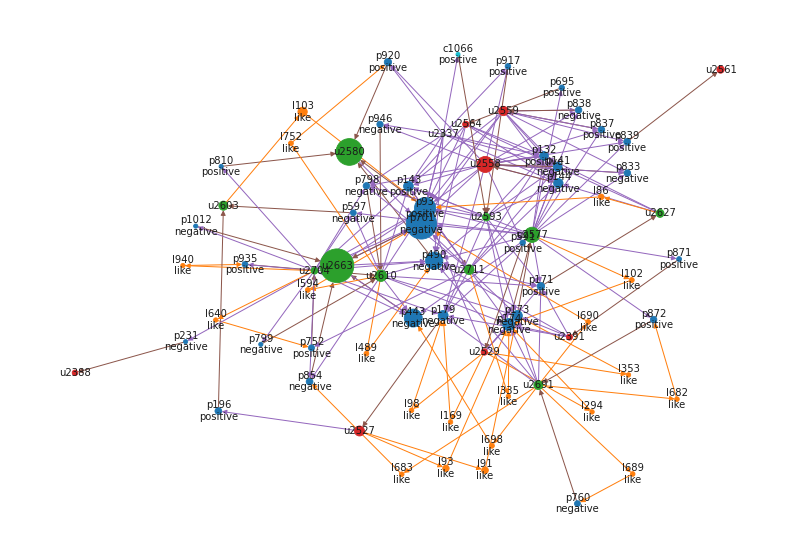

In [37]:
# pos = nx.drawing.nx_agraph.graphviz_layout(moment_graph, prog="dot")
pos = nx.drawing.nx_agraph.graphviz_layout(moment_graph)
# pos = nx.spring_layout(moment_graph, iterations=3, seed=3)

fig = plt.figure(figsize=(14, 10))
ax = fig.subplots()

nx.draw(
    moment_graph, ax=ax,
    pos=pos,
    with_labels=True,
#     node_color=[use_color[color_map[moment_graph.nodes[n]["kind"]]] for n in moment_graph.nodes],
    node_color=[use_color[color_map[moment_graph.nodes[n]["kind"]]]
                if n[0] != "u" else use_color[color_map[moment_graph.nodes[n]["color"]]]
                for n in moment_graph.nodes],
    edge_color=[use_color[color_map[moment_graph.edges[e]["kind"]]] for e in moment_graph.edges],
    labels={n: f"{n}\n{moment_graph.nodes[n]['senti']}" if moment_graph.nodes[n]['kind'] != "user" else n for n in moment_graph.nodes},
    font_size=10,
    node_size=[pr_value[n]*len(moment_graph)*100 for n in moment_graph],
)

nx.draw_networkx_edge_labels(
    subG, pos=pos, ax=ax,
#     edge_labels={e: f"{moment_graph.edges[e]['time']:%d-%H:%M}" for e in moment_graph.edges},
    edge_labels={e: "" for e in moment_graph.edges},
    font_size=8,
)

print(len(moment_graph))